<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/snakemake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction to Snakemake: Concepts, Syntax, and a Real Geospatial Example

**Notebook goals:**  
- Understand why we use workflow systems (reproducibility, automation, provenance).  
- Learn Snakemake's core model: rules → DAG → selective recomputation.  
- Practice wildcards and rule chaining on a tiny example.  
- Build a clean script-based minimal pipeline (using the `snakemake` object).  
- Implement a realistic MTBS rasterization pipeline with a download step and result visualization.  
- Visualize DAGs with Graphviz and use `snakemake -np` to preview execution.



## What is Snakemake (in a nutshell)?

- A declarative workflow engine inspired by GNU Make, written in Python.  
- You define rules* that describe how to turn input* into outputs.  
- Snakemake builds a **Directed Acyclic Graph (DAG)** from your rules and runs only what’s needed.  
- It supports **wildcards**, **per-rule environments** (conda/containers), and scales from **laptop → HPC → cloud** with minimal changes (HPC later).

**Key benefits:** reproducibility, modularity, parallelism, provenance, portability.



## Motivation: why workflows?

- Analyses quickly become multi-step pipelines; manually rerunning steps is error-prone.  
- Reproducibility demands that steps, parameters, and software are codified.
- Workflow engines give you a concise, executable narrative of how results are produced.



## Core Snakemake syntax & methodology

A **Snakefile** contains `rule`s. Each rule specifies **inputs**, **outputs**, and how to run (via `shell:` or `script:`).

```python
rule example:
    input:  "data/raw.csv"
    output: "results/clean.csv"
    params: threshold=0.2
    shell:  "python scripts/clean.py {input} {output} {params.threshold}"
```

- Snakemake links rules by matching **inputs** of one rule to **outputs** of another forming a a DAG, or directed acyclic graph.  
- A special `rule all` lists your **final targets**; running `snakemake` with no args will build those.  
- Use `snakemake -np` to **dry-run** and print the plan.



## Wildcards (pattern generalization)

Wildcards let one rule handle many files by pattern-matching parts of filenames.

**Example:** process 3 samples `A,B,C` with one rule.


In [ ]:

%%bash
set -e
mkdir -p wild_demo/data wild_demo/results
printf "alpha\n" > wild_demo/data/A.csv
printf "beta\n"  > wild_demo/data/B.csv
printf "gamma\n" > wild_demo/data/C.csv
cat > wild_demo/Snakefile <<'EOF'
rule all:
    input:
        expand("results/{sample}.txt", sample=["A","B","C"])

rule process:
    input:
        "data/{sample}.csv"
    output:
        "results/{sample}.txt"
    shell:
        r"echo processed {input} > {output}"
EOF


This command will do a dry run that just outputs the execution plan.

In [ ]:

%%bash
cd wild_demo
snakemake -np

host: dl
Building DAG of jobs...
Job stats:
job        count
-------  -------
all            1
process        3
total          4


[Tue Nov 11 16:34:33 2025]
rule process:
    input: data/B.csv
    output: results/B.txt
    jobid: 2
    reason: Missing output files: results/B.txt
    wildcards: sample=B
    resources: tmpdir=<TBD>

echo processed data/B.csv > results/B.txt

[Tue Nov 11 16:34:33 2025]
rule process:
    input: data/C.csv
    output: results/C.txt
    jobid: 3
    reason: Missing output files: results/C.txt
    wildcards: sample=C
    resources: tmpdir=<TBD>

echo processed data/C.csv > results/C.txt

[Tue Nov 11 16:34:33 2025]
rule process:
    input: data/A.csv
    output: results/A.txt
    jobid: 1
    reason: Missing output files: results/A.txt
    wildcards: sample=A
    resources: tmpdir=<TBD>

echo processed data/A.csv > results/A.txt

[Tue Nov 11 16:34:33 2025]
rule all:
    input: results/A.txt, results/B.txt, results/C.txt
    jobid: 0
    reason: Input files up

Let's look at the DAG for this example.

In [ ]:

%%bash
cd wild_demo
snakemake -j 2 -p
snakemake --rulegraph | dot -Tpng > rulegraph.png || true


Assuming unrestricted shared filesystem usage.
host: dl
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 2
Rules claiming more threads will be scaled down.
Job stats:
job        count
-------  -------
all            1
process        3
total          4

Select jobs to execute...
Execute 2 jobs...

[Tue Nov 11 16:35:55 2025]
localrule process:
    input: data/B.csv
    output: results/B.txt
    jobid: 2
    reason: Missing output files: results/B.txt
    wildcards: sample=B
    resources: tmpdir=/tmp

echo processed data/B.csv > results/B.txt

[Tue Nov 11 16:35:55 2025]
localrule process:
    input: data/C.csv
    output: results/C.txt
    jobid: 3
    reason: Missing output files: results/C.txt
    wildcards: sample=C
    resources: tmpdir=/tmp

echo processed data/C.csv > results/C.txt
[Tue Nov 11 16:35:55 2025]
Finished job 2.
1 of 4 steps (25%) done
Select jobs to execute...
Execute 1 jobs...

[Tue Nov 11 16:35:55 2025]
localrule process:
    input: data/A.csv
    o

* It's not really that interesting in this case.

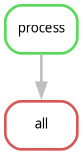

In [ ]:

from IPython.display import Image, display
from pathlib import Path
p = Path("wild_demo/rulegraph.png")
display(Image(filename=str(p))) if p.exists() else print("Install graphviz to render the rulegraph (conda install -c conda-forge graphviz).")



## A Longer Workflow


Let's look at a slightly more elaborate example. Our goal here is to develop a multistep workflow in which we "simulate" some data (generate some random data), "analyze" the data (just computing its mean), and plot it. Each of these steps will involve different Python scripts.

The first thing we'll do is create a directory for this workflow and its data, then define a config file.

In [ ]:

%%bash
set -e
mkdir -p demo_scriptmode/{scripts,data,results}
cat > demo_scriptmode/config.yaml <<'YAML'
scripts:
  simulate: scripts/simulate.py
  analyze: scripts/analyze.py
  plot: scripts/plot.py
YAML


Now we'll create scripts for each of the 3 tasks, `simulate.py`, `analyze.py`, and `plot.py`. These scripts will make use of the `snakemake` object. Essentially, the script can reference a snakemake configuration object to get certain configuration parameters like the input and output file names.

### Simulate
This just generates some random data. It will reference the output directory specified in the snakemake configuration.

In [ ]:

%%writefile demo_scriptmode/scripts/simulate.py
import numpy as np
from pathlib import Path
Path(snakemake.output[0]).parent.mkdir(parents=True, exist_ok=True)
np.savetxt(snakemake.output[0], np.random.randn(1000))


Writing demo_scriptmode/scripts/simulate.py


### Analyze
This will just load in the data generated by simulate and compute its mean. This again uses the snakemake object to reference the input / output file names specified in the Snakefile for this rule.

In [ ]:

%%writefile demo_scriptmode/scripts/analyze.py
import numpy as np
from pathlib import Path
x = np.loadtxt(snakemake.input[0])
Path(snakemake.output[0]).parent.mkdir(parents=True, exist_ok=True)
with open(snakemake.output[0], "w") as f:
    f.write(f"mean={x.mean():.4f}\nstd={x.std():.4f}\n")


Writing demo_scriptmode/scripts/analyze.py


### Plot

The last step in the pipeline will just be to plot the mean and std of the data and save it to a file.

In [ ]:

%%writefile demo_scriptmode/scripts/plot.py
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from pathlib import Path
kv = dict(line.strip().split("=", 1) for line in open(snakemake.input[0]) if "=" in line)
mean = float(kv.get("mean", 0.0)); std = float(kv.get("std", 0.0))
Path(snakemake.output[0]).parent.mkdir(parents=True, exist_ok=True)
plt.figure(); plt.bar(["mean","std"], [mean, std]); plt.title("Demo Plot")
plt.savefig(snakemake.output[0], dpi=120, bbox_inches="tight")


Writing demo_scriptmode/scripts/plot.py


### Snakefile
Here we define the Snakefile with four rules. The target output is plot.png. To get there, Snakemake will figure our we need to execute simulate, analyze, and plot in sequence, taking in inputs in the previous step to generate the next step.

In [ ]:

%%writefile demo_scriptmode/Snakefile
configfile: "config.yaml"

rule all:
    input:
        "results/plot.png"

rule simulate:
    output:
        "data/random.txt"
    script:
        config["scripts"]["simulate"]

rule analyze:
    input:
        "data/random.txt"
    output:
        "results/stats.txt"
    script:
        config["scripts"]["analyze"]

rule plot:
    input:
        "results/stats.txt"
    output:
        "results/plot.png"
    script:
        config["scripts"]["plot"]

Overwriting demo_scriptmode/Snakefile


Let'd look at the DAG for this example.

In [ ]:

%%bash
cd demo_scriptmode
snakemake -np
snakemake --rulegraph | dot -Tpng > rulegraph.png || true

host: dl
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


Building DAG of jobs...


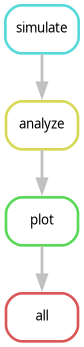

In [ ]:

from IPython.display import Image, display
from pathlib import Path
p = Path("demo_scriptmode/rulegraph.png")
display(Image(filename=str(p)))


Now let's run the pipeline.

In [ ]:
%%bash
cd demo_scriptmode
snakemake -R all

Assuming unrestricted shared filesystem usage.
host: dl
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 28
Rules claiming more threads will be scaled down.
Job stats:
job      count
-----  -------
all          1
total        1

Select jobs to execute...
Execute 1 jobs...

[Tue Nov 11 17:02:16 2025]
localrule all:
    input: results/plot.png
    jobid: 0
    reason: Forced execution
    resources: tmpdir=/tmp

[Tue Nov 11 17:02:16 2025]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2025-11-11T170216.554713.snakemake.log


We can look at our file contents and verify that all intermediary results were written and we now have a silly plot.

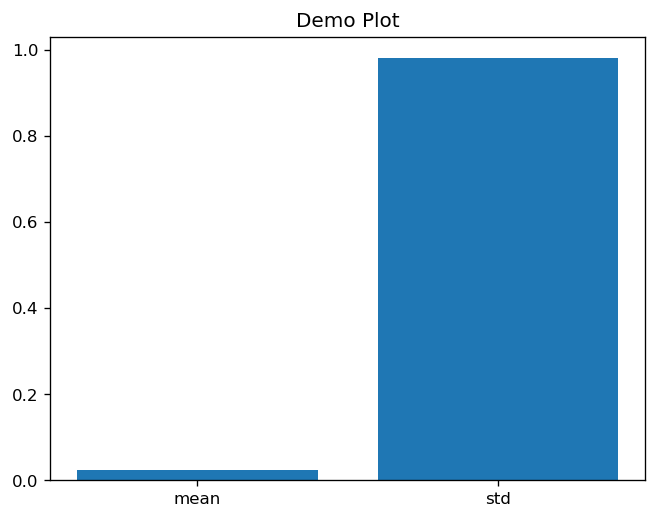

In [ ]:

from IPython.display import Image, display
from pathlib import Path
p = Path("demo_scriptmode/results/plot.png")
display(Image(filename=str(p)))



## MTBS Rasterization Example


With some basics established, lets look at an example that is actually useful. We'll look at a dataset of fire perimeters from 1984-2024 from [MTBS](https://www.mtbs.gov/). The data is a shapefile, where each record represents a different fire perimeter. For analysis or ML tasks, we might want to convert this shapefile representation to a raster representation. Hence, that's what we'll do in this example.

### Setting up a Directory
Initially, let's just create some new directories for this example.

In [ ]:
%%bash
set -e
mkdir -p mtbs_demo/{scripts,env,results,raw,features,zarr,logs}

### Conda Environment
We'll use the ability of snakemake to use a particular conda environment to execute rules. The processing scripts will rely on this envionrment.yml.

In [ ]:
%%writefile mtbs_demo/env/environment.yml
name: mtbs2zarr
channels:
  - conda-forge
dependencies:
  - python=3.11
  - snakemake-minimal>=7,<9
  - geopandas
  - pyogrio
  - shapely
  - rasterio
  - rioxarray
  - xarray
  - zarr
  - numpy
  - pyproj
  - fsspec
  - dask
  - matplotlib-base
  - graphviz

Writing mtbs_demo/env/environment.yml


### Config
For our config.yaml we'll use a file with just a couple parameters like the url to download the data, an ouput directory, the projection, and the maximum number of fires to process for testing.

In [ ]:
%%writefile mtbs_demo/config.yaml
# Path to your existing unzipped MTBS perimeter directory
mtbs_dir: "raw/"

# Target grid parameters
crs: "EPSG:5070"
resolution_m: 50
bounds:
max_fires: 50
outdir: "results"

Overwriting mtbs_demo/config.yaml


## Scripts

Rasterizing each of the fire outlines will consist of three steps. The first step will just involve a bash command, while the second and third steps involve their own Python scripts outlined below.

### Split Features
After the data is downloaded, the split features script basically just writes out a separate geojson for every fire in the dataset. These geojson files will serve as inputs for the next step.

In [ ]:

%%writefile mtbs_demo/scripts/split_features.py
import argparse, os, glob
import geopandas as gpd

ap = argparse.ArgumentParser()
ap.add_argument("--in_dir", required=True)
ap.add_argument("--out_dir", required=True)
ap.add_argument("--limit", type=int, default=0)
args = ap.parse_args()

os.makedirs(args.out_dir, exist_ok=True)

candidates = glob.glob(os.path.join(args.in_dir, "**", "*.shp"), recursive=True)
if not candidates:
    raise SystemExit("No shapefile found under input directory.")
shp = candidates[0]

gdf = gpd.read_file(shp).explode(index_parts=False, ignore_index=True)

fid_field = next((c for c in ["Event_ID","EVENT_ID","MTBS_ID","Fire_ID","FIRE_ID"] if c in gdf.columns), None)

count = 0
for i, row in gdf.iterrows():
    if args.limit and count >= args.limit:
        break
    if row.geometry is None or row.geometry.is_empty:
        continue

    fid = str(row.get(fid_field, f"fire_{i}")).replace("/", "_")
    outp = os.path.join(args.out_dir, f"{fid}.geojson")

    # Construct a single-row GeoDataFrame and write it via GDAL/OGR
    one = gpd.GeoDataFrame([row.drop(labels=["geometry"])], geometry=[row.geometry], crs=gdf.crs)
    one.to_file(outp, driver="GeoJSON")  # Fiona/OGR handles types

    count += 1

print(f"Wrote {count} features to {args.out_dir}")


Overwriting mtbs_demo/scripts/split_features.py


## Rasterize
The second script will simply rasterize the outline stored in a particular geojson file generated by the first step and save it as a zarr store, which is a bit like a NetCDF.

In [ ]:
%%writefile mtbs_demo/scripts/rasterize_fire.py
import argparse, os, math, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import features
import xarray as xr
from pyproj import CRS

def json_safe(v):
    if v is None:
        return None
    # NaN -> None
    if isinstance(v, float) and math.isnan(v):
        return None
    # pandas/py datetime -> ISO8601
    if isinstance(v, (pd.Timestamp, datetime.datetime, datetime.date)):
        return pd.to_datetime(v).isoformat()
    # numpy scalars -> Python scalars
    if isinstance(v, (np.generic,)):
        return v.item()
    # lists/arrays -> lists of safe scalars
    if isinstance(v, (list, tuple, np.ndarray)):
        return [json_safe(x) for x in v]
    # fall back to str for anything still weird (e.g., Decimals)
    try:
        _ = v.__class__.__name__
        _ = str(v)
    except Exception:
        return None
    # Keep simple builtins as-is; complex objects -> str
    return v if isinstance(v, (bool, int, float, str)) else str(v)

ap = argparse.ArgumentParser()
ap.add_argument("--fire", required=True, help="single-fire GeoJSON")
ap.add_argument("--crs", default="EPSG:5070")
ap.add_argument("--res", type=float, default=120.0, help="cell size in target units")
ap.add_argument("--bounds", default=None, help="xmin,ymin,xmax,ymax in target CRS (optional)")
ap.add_argument("--out_dir", required=True)
args = ap.parse_args()

os.makedirs(args.out_dir, exist_ok=True)

gdf = gpd.read_file(args.fire)
if len(gdf) != 1:
    raise SystemExit("Expected a single-feature GeoJSON")

# Choose an ID
fid = None
for key in ["Event_ID","EVENT_ID","MTBS_ID","Fire_ID","FIRE_ID"]:
    if key in gdf.columns:
        fid = str(gdf.iloc[0][key]); break
if not fid:
    fid = os.path.splitext(os.path.basename(args.fire))[0]

# Reproject to target CRS
target_crs = CRS.from_user_input(args.crs)
gdf = gdf.to_crs(target_crs)

geom = gdf.geometry.iloc[0]
minx, miny, maxx, maxy = geom.bounds

# Optional fixed grid
if args.bounds:
    bx = [float(v) for v in args.bounds.split(",")]
    minx, miny, maxx, maxy = bx

res = float(args.res)
width  = int(np.ceil((maxx - minx) / res))
height = int(np.ceil((maxy - miny) / res))
transform = rasterio.transform.from_origin(minx, maxy, res, res)

# Rasterize 0/1 mask
mask = features.rasterize(
    [(geom, 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype="uint8",
)

# Coordinates at pixel centers
y_coords = np.arange(maxy - res/2, maxy - res/2 - height*res, -res)
x_coords = np.arange(minx + res/2, minx + res/2 + width*res,  res)

da = xr.DataArray(
    mask,
    dims=("y","x"),
    coords={"y": y_coords, "x": x_coords},
    name="burn_mask"
)
# Build JSON-safe attrs (skip geometry)
attrs = {
    "crs": str(args.crs),     # ensure string
    "resolution": float(res),
    "fire_id": str(fid),
}
for c in gdf.columns:
    if c == "geometry":
        continue
    attrs[c] = json_safe(gdf.iloc[0][c])

da = da.assign_attrs(attrs)

# Write one Zarr per fire
out_path = os.path.join(args.out_dir, f"{fid}.zarr")
da.to_dataset().chunk({"y": 1024, "x": 1024}).to_zarr(out_path, mode="w")
print(f"Wrote {out_path}")


Overwriting mtbs_demo/scripts/rasterize_fire.py


## Snakefile

After the scripts are define, we can create our Snakefile that sets up the workflow.

In [ ]:

%%writefile mtbs_demo/Snakefile
###############################################
# Snakefile: MTBS fire features → per-fire Zarr
#
# What this does (high level):
# 1) split_features (CHECKPOINT) scans MTBS perimeters and writes:
#      OUTDIR/features/{fire_id}.geojson
#    This is a checkpoint because we don't know fire_ids until this runs.
# 2) rasterize_fire runs once per discovered fire_id and writes:
#      OUTDIR/zarr/{fire_id}.zarr   (a Zarr directory per fire)
#
# Why a checkpoint?
# - The downstream targets (the set of fire_ids) are discovered at runtime
#   by listing *.geojson produced by split_features. Snakemake's checkpoint
#   lets us "pause", discover outputs, and then fan out rules dynamically.
#
# Notes:
# - We wrap directory-like outputs with directory(...) so Snakemake treats
#   them atomically (based on mtime), not by hashing their contents.
# - Optional config entries (max_fires, bounds) are cleanly handled so they
#   only appear on the CLI if provided.
###############################################

import os
import glob

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------
# Required in config.yaml:
#   outdir:        base output directory (e.g., "mtbs_demo/out")
#   mtbs_dir:      path to input MTBS perimeters directory
#   crs:           target CRS for rasterization (e.g., "EPSG:5070")
#   resolution_m:  raster resolution in meters (e.g., 30)
#
# Optional:
#   max_fires:     int, limit number of fires processed by split_features
#   bounds:        string, CLI-passed as --bounds "<value>" if present
#                  (ensure format matches what rasterize_fire.py expects)
# -----------------------------------------------------------------------------

configfile: "config.yaml"
OUTDIR = config["outdir"]

# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------
def _fire_ids_from_features_dir(features_dir: str):
    """
    Inspect the 'features_dir' for files named *.geojson and derive fire_ids
    from basenames. Example:
       features_dir/CA-12345.geojson  -> fire_id="CA-12345"
    """
    files = glob.glob(os.path.join(features_dir, "*.geojson"))
    ids = [os.path.splitext(os.path.basename(f))[0] for f in files]
    return ids


def zarr_targets(wildcards):
    """
    Dynamic input function for rule `all`.

    This function *waits* for the checkpoint `split_features` to finish,
    then looks inside its declared output directory to discover all the fire_ids,
    and finally returns the list of desired Zarr targets for rule `all`.
    """
    ckpt = checkpoints.split_features.get()              # block until checkpoint completes
    features_dir = ckpt.output.features_dir
    fire_ids = _fire_ids_from_features_dir(features_dir) # discover fan-out
    return expand(os.path.join(OUTDIR, "zarr", "{fire_id}.zarr"),
                  fire_id=fire_ids)

# -----------------------------------------------------------------------------
# DAG anchor: build everything (one Zarr per discovered fire)
# -----------------------------------------------------------------------------
rule all:
    """
    Default goal: after discovering fire_ids via checkpoint, produce all
    per-fire Zarr directories.
    """
    input:
        zarr_targets

# -----------------------------------------------------------------------------
# Checkpoint: split MTBS perimeters into one GeoJSON per fire
# -----------------------------------------------------------------------------
checkpoint split_features:
    """
    A checkpoint because the set of downstream targets depends on whatever
    *.geojson files this produces. It writes a directory of per-fire features.
    """
    input:
        perims_dir = directory(config["mtbs_dir"])  # treat input as a directory dependency
    output:
        features_dir = directory(os.path.join(OUTDIR, "features"))
    params:
        # Include "--limit N" only if config['max_fires'] is set and nonzero.
        limit = lambda wc: (f"--limit {config['max_fires']}"
                            if config.get("max_fires", 0) else "")
    conda:
        "env/environment.yml"  # reproducible runtime for the Python scripts
    shell:
        r"""
        python scripts/split_features.py \
          --in_dir {input.perims_dir} \
          --out_dir {output.features_dir} \
          {params.limit}
        """

# -----------------------------------------------------------------------------
# Per-fire rasterization to Zarr
# -----------------------------------------------------------------------------
rule rasterize_fire:
    """
    For each discovered fire_id, read its GeoJSON and produce a Zarr directory.
    The wildcard {fire_id} comes from the targets returned by zarr_targets().
    """
    input:
        # Depend on the specific fire's GeoJSON produced by the checkpoint.
        lambda wc: os.path.join(OUTDIR, "features", f"{wc.fire_id}.geojson")
    output:
        # Zarr stores are directory-based; wrap with directory(...) so Snakemake
        # treats them as atomic outputs by directory mtime.
        zarr_dir = directory(os.path.join(OUTDIR, "zarr", "{fire_id}.zarr"))
    params:
        crs   = config["crs"],
        res   = config["resolution_m"],
        # Include "--bounds ..." only if provided in config, otherwise empty.
        bounds = lambda wc: (f"--bounds {config['bounds']}"
                             if config.get("bounds") else "")
    conda:
        "env/environment.yml"
    shell:
        r"""
        python scripts/rasterize_fire.py \
          --fire {input} \
          --crs {params.crs} \
          --res {params.res} \
          {params.bounds} \
          --out_dir {OUTDIR}/zarr
        """

# -----------------------------------------------------------------------------
# Tips:
# - `snakemake -n` shows the planned DAG (great for verifying discovery logic).
# - `snakemake -c 8` runs multiple fires in parallel.
# - Add `log:` directives if you want per-rule logs for debugging.
# - If you change discovery logic, `--forcerun split_features` will re-enumerate
#   fire_ids and re-trigger downstream rules as needed.
# -----------------------------------------------------------------------------


Overwriting mtbs_demo/Snakefile


In [ ]:
%%bash
cd mtbs_demo
snakemake --use-conda -j 4 -p

The flag 'directory' used in rule split_features is only valid for outputs, not inputs.
Assuming unrestricted shared filesystem usage.
host: dl
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 4
Rules claiming more threads will be scaled down.
Job stats:
job               count
--------------  -------
all                   1
split_features        1
total                 2

Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:19 2025]
localcheckpoint split_features:
    input: raw
    output: results/features
    jobid: 1
    reason: Code has changed since last execution
    resources: tmpdir=/tmp
DAG of jobs will be updated after completion.


        python scripts/split_features.py \
          --in_dir raw \
          --out_dir results/features \
          --limit 50
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_


Wrote 50 features to results/features


[Wed Nov 12 08:21:21 2025]
Finished job 1.
1 of 2 steps (50%) done
Select jobs to execute...
Execute 4 jobs...

[Wed Nov 12 08:21:21 2025]
localrule rasterize_fire:
    input: results/features/SD4331510234619850703.geojson
    output: results/zarr/SD4331510234619850703.zarr
    jobid: 8
    reason: Missing output files: results/zarr/SD4331510234619850703.zarr; Code has changed since last execution
    wildcards: fire_id=SD4331510234619850703
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/SD4331510234619850703.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_

[Wed Nov 12 08:21:21 2025]
localrule rasterize_fire:
    input: results/features/SD4333910086819850624.geojson
    output: results/zarr/SD4333910086819850624.zarr
    jobid: 36
    reason: Missing output files: results/zarr/SD4333

Wrote results/zarr/SD4331510234619850703.zarr
Wrote results/zarr/SD4333910086819850624.zarr
Wrote results/zarr/AK6431115699319850801.zarr
Wrote results/zarr/CA3985112177219850611.zarr


[Wed Nov 12 08:21:22 2025]
Finished job 8.
2 of 52 steps (4%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:23 2025]
localrule rasterize_fire:
    input: results/features/AK6654114670119850715.geojson
    output: results/zarr/AK6654114670119850715.zarr
    jobid: 7
    reason: Missing output files: results/zarr/AK6654114670119850715.zarr; Code has changed since last execution
    wildcards: fire_id=AK6654114670119850715
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6654114670119850715.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:23 2025]
Finished job 22.
3 of 52 steps (6%) done
[Wed Nov 12 08:21:23 2025]
Finished job 36.
4 of 52 steps (8%) done
[Wed Nov 12 08:21:23 2025]
Finished job 29.
5 of 52 steps (10%) done
Select jobs to execute...


Wrote results/zarr/AK6654114670119850715.zarr
Wrote results/zarr/CA3544311877719850503.zarr
Wrote results/zarr/CA3601111879719850712.zarr
Wrote results/zarr/AK6669514282519850725.zarr


[Wed Nov 12 08:21:24 2025]
Finished job 7.
6 of 52 steps (12%) done
Execute 1 jobs...

[Wed Nov 12 08:21:24 2025]
localrule rasterize_fire:
    input: results/features/SD4340510225419850325.geojson
    output: results/zarr/SD4340510225419850325.zarr
    jobid: 49
    reason: Missing output files: results/zarr/SD4340510225419850325.zarr; Code has changed since last execution
    wildcards: fire_id=SD4340510225419850325
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/SD4340510225419850325.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:24 2025]
Finished job 32.
7 of 52 steps (13%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:24 2025]
localrule rasterize_fire:
    input: results/features/CA3672712076819850609.geojson
    output: results/zarr/CA367

Wrote results/zarr/SD4340510225419850325.zarr
Wrote results/zarr/CA3672712076819850609.zarr
Wrote results/zarr/AK6755714325519850730.zarr
Wrote results/zarr/FL2622208075919850225.zarr


[Wed Nov 12 08:21:25 2025]
Finished job 49.
10 of 52 steps (19%) done
Execute 1 jobs...

[Wed Nov 12 08:21:25 2025]
localrule rasterize_fire:
    input: results/features/SD4317510096019850704.geojson
    output: results/zarr/SD4317510096019850704.zarr
    jobid: 21
    reason: Missing output files: results/zarr/SD4317510096019850704.zarr; Code has changed since last execution
    wildcards: fire_id=SD4317510096019850704
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/SD4317510096019850704.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:25 2025]
Finished job 14.
11 of 52 steps (21%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:25 2025]
localrule rasterize_fire:
    input: results/features/SD4338110196719850705.geojson
    output: results/zarr/SD

Wrote results/zarr/SD4317510096019850704.zarr
Wrote results/zarr/SD4338110196719850705.zarr
Wrote results/zarr/WA4820811967519850623.zarr
Wrote results/zarr/AK6256215664519850720.zarr


[Wed Nov 12 08:21:26 2025]
Finished job 21.
14 of 52 steps (27%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:26 2025]
localrule rasterize_fire:
    input: results/features/AK6599715513019850731.geojson
    output: results/zarr/AK6599715513019850731.zarr
    jobid: 35
    reason: Missing output files: results/zarr/AK6599715513019850731.zarr; Code has changed since last execution
    wildcards: fire_id=AK6599715513019850731
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6599715513019850731.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:26 2025]
Finished job 12.
15 of 52 steps (29%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:26 2025]
localrule rasterize_fire:
    input: results/features/CA4034312052019850807.geojson
 

Wrote results/zarr/AK6599715513019850731.zarr
Wrote results/zarr/CA4034312052019850807.zarr
Wrote results/zarr/AK6712614205419850717.zarr
Wrote results/zarr/SD4333310212819850414.zarr


[Wed Nov 12 08:21:28 2025]
Finished job 35.
18 of 52 steps (35%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:28 2025]
localrule rasterize_fire:
    input: results/features/AK6922215430619850809.geojson
    output: results/zarr/AK6922215430619850809.zarr
    jobid: 18
    reason: Missing output files: results/zarr/AK6922215430619850809.zarr; Code has changed since last execution
    wildcards: fire_id=AK6922215430619850809
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6922215430619850809.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:28 2025]
Finished job 44.
19 of 52 steps (37%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:28 2025]
localrule rasterize_fire:
    input: results/features/AK6283615543219850803.geojson
 

Wrote results/zarr/AK6922215430619850809.zarr
Wrote results/zarr/AK6283615543219850803.zarr
Wrote results/zarr/CA3637912058319850706.zarr
Wrote results/zarr/AK6543915545119850713.zarr


[Wed Nov 12 08:21:29 2025]
Finished job 18.
22 of 52 steps (42%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:29 2025]
localrule rasterize_fire:
    input: results/features/AK6590715501219850807.geojson
    output: results/zarr/AK6590715501219850807.zarr
    jobid: 46
    reason: Missing output files: results/zarr/AK6590715501219850807.zarr; Code has changed since last execution
    wildcards: fire_id=AK6590715501219850807
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6590715501219850807.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:29 2025]
Finished job 15.
23 of 52 steps (44%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:29 2025]
localrule rasterize_fire:
    input: results/features/CA3844612209319850831.geojson
 

Wrote results/zarr/AK6590715501219850807.zarr
Wrote results/zarr/CA3844612209319850831.zarr
Wrote results/zarr/CA3590312056319850702.zarr
Wrote results/zarr/AK6244915566819850730.zarr


[Wed Nov 12 08:21:30 2025]
Finished job 46.
26 of 52 steps (50%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:30 2025]
localrule rasterize_fire:
    input: results/features/AK6293715788819850728.geojson
    output: results/zarr/AK6293715788819850728.zarr
    jobid: 19
    reason: Missing output files: results/zarr/AK6293715788819850728.zarr; Code has changed since last execution
    wildcards: fire_id=AK6293715788819850728
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6293715788819850728.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:30 2025]
Finished job 40.
27 of 52 steps (52%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:30 2025]
localrule rasterize_fire:
    input: results/features/AK6547615382919850801.geojson
 

Wrote results/zarr/AK6293715788819850728.zarr
Wrote results/zarr/AK6547615382919850801.zarr
Wrote results/zarr/SD4342910201819850703.zarr
Wrote results/zarr/SD4308710266019850704.zarr


[Wed Nov 12 08:21:31 2025]
Finished job 19.
30 of 52 steps (58%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:31 2025]
localrule rasterize_fire:
    input: results/features/NV4024611989419850619.geojson
    output: results/zarr/NV4024611989419850619.zarr
    jobid: 37
    reason: Missing output files: results/zarr/NV4024611989419850619.zarr; Code has changed since last execution
    wildcards: fire_id=NV4024611989419850619
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/NV4024611989419850619.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:32 2025]
Finished job 10.
31 of 52 steps (60%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:32 2025]
localrule rasterize_fire:
    input: results/features/CO4075010780119851006.geojson
 

Wrote results/zarr/NV4024611989419850619.zarr
Wrote results/zarr/CO4075010780119851006.zarr
Wrote results/zarr/OR4479412120619850615.zarr
Wrote results/zarr/CA3673911825219850706.zarr


[Wed Nov 12 08:21:33 2025]
Finished job 37.
34 of 52 steps (65%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:33 2025]
localrule rasterize_fire:
    input: results/features/AZ3259810920419850704.geojson
    output: results/zarr/AZ3259810920419850704.zarr
    jobid: 11
    reason: Missing output files: results/zarr/AZ3259810920419850704.zarr; Code has changed since last execution
    wildcards: fire_id=AZ3259810920419850704
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AZ3259810920419850704.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:33 2025]
Finished job 30.
35 of 52 steps (67%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:33 2025]
localrule rasterize_fire:
    input: results/features/AK6328715436819850803.geojson
 

Wrote results/zarr/AZ3259810920419850704.zarr
Wrote results/zarr/AK6328715436819850803.zarr
Wrote results/zarr/CA3603712055919850706.zarr
Wrote results/zarr/CA3599412057519850706.zarr


[Wed Nov 12 08:21:34 2025]
Finished job 11.
38 of 52 steps (73%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:34 2025]
localrule rasterize_fire:
    input: results/features/WA4845711860619850830.geojson
    output: results/zarr/WA4845711860619850830.zarr
    jobid: 42
    reason: Missing output files: results/zarr/WA4845711860619850830.zarr; Code has changed since last execution
    wildcards: fire_id=WA4845711860619850830
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/WA4845711860619850830.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:34 2025]
Finished job 6.
39 of 52 steps (75%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:34 2025]
localrule rasterize_fire:
    input: results/features/CA4030512015819850519.geojson
  

Wrote results/zarr/WA4845711860619850830.zarr
Wrote results/zarr/CA4030512015819850519.zarr
Wrote results/zarr/AK6626515450319850731.zarr
Wrote results/zarr/AK6462715405119850731.zarr


[Wed Nov 12 08:21:35 2025]
Finished job 42.
42 of 52 steps (81%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:35 2025]
localrule rasterize_fire:
    input: results/features/WA4799411870619850704.geojson
    output: results/zarr/WA4799411870619850704.zarr
    jobid: 27
    reason: Missing output files: results/zarr/WA4799411870619850704.zarr; Code has changed since last execution
    wildcards: fire_id=WA4799411870619850704
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/WA4799411870619850704.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:35 2025]
Finished job 9.
43 of 52 steps (83%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:35 2025]
localrule rasterize_fire:
    input: results/features/ID4307811577519850615.geojson
  

Wrote results/zarr/WA4799411870619850704.zarr


/home/bizon/snakemake/mtbs_demo/.snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Wrote results/zarr/ID4307811577519850615.zarr
Wrote results/zarr/AZ3178311066219850302.zarr
Wrote results/zarr/AK6521015526519850803.zarr


[Wed Nov 12 08:21:37 2025]
Finished job 27.
46 of 52 steps (88%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:37 2025]
localrule rasterize_fire:
    input: results/features/AK6260315742119850801.geojson
    output: results/zarr/AK6260315742119850801.zarr
    jobid: 23
    reason: Missing output files: results/zarr/AK6260315742119850801.zarr; Code has changed since last execution
    wildcards: fire_id=AK6260315742119850801
    resources: tmpdir=/tmp


        python scripts/rasterize_fire.py \
          --fire results/features/AK6260315742119850801.geojson \
          --crs EPSG:5070 \
          --res 50 \
           \
          --out_dir results/zarr
        
Activating conda environment: .snakemake/conda/44f4891a6bcca0248cf4ac029ec9560d_
[Wed Nov 12 08:21:37 2025]
Finished job 34.
47 of 52 steps (90%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:37 2025]
localrule rasterize_fire:
    input: results/features/AK6590514549519850806.geojson
 

Wrote results/zarr/AK6260315742119850801.zarr
Wrote results/zarr/AK6590514549519850806.zarr


[Wed Nov 12 08:21:38 2025]
Finished job 23.
50 of 52 steps (96%) done
[Wed Nov 12 08:21:38 2025]
Finished job 52.
51 of 52 steps (98%) done
Select jobs to execute...
Execute 1 jobs...

[Wed Nov 12 08:21:38 2025]
localrule all:
    input: results/zarr/CA3637912058319850706.zarr, results/zarr/SD4342910201819850703.zarr, results/zarr/AK6328715436819850803.zarr, results/zarr/AK6654114670119850715.zarr, results/zarr/SD4331510234619850703.zarr, results/zarr/CA4030512015819850519.zarr, results/zarr/AK6547615382919850801.zarr, results/zarr/AZ3259810920419850704.zarr, results/zarr/SD4338110196719850705.zarr, results/zarr/AK6256215664519850720.zarr, results/zarr/CA3672712076819850609.zarr, results/zarr/AK6283615543219850803.zarr, results/zarr/AZ3178311066219850302.zarr, results/zarr/CA3599412057519850706.zarr, results/zarr/AK6922215430619850809.zarr, results/zarr/AK6293715788819850728.zarr, results/zarr/CA3673911825219850706.zarr, results/zarr/SD4317510096019850704.zarr, results/zarr/AK643111569


### Quick verification plot


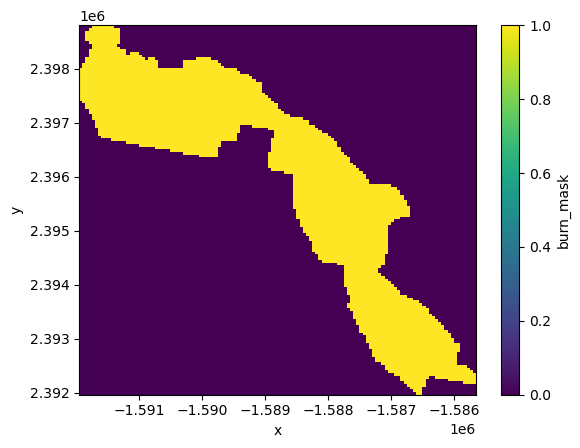

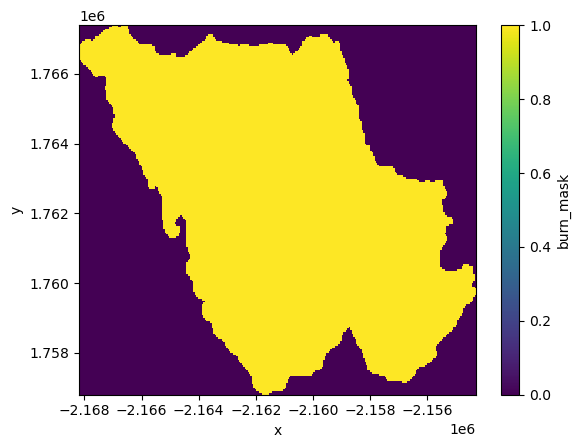

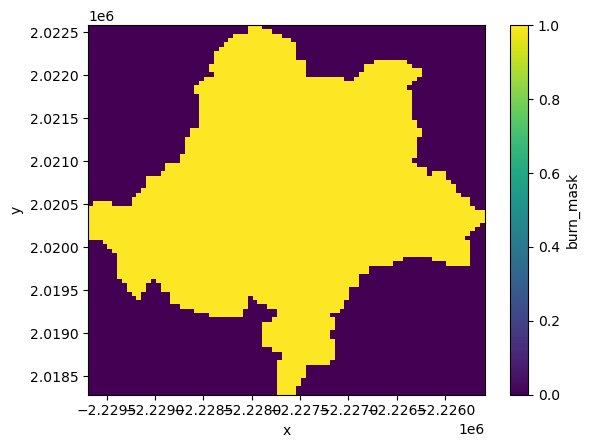

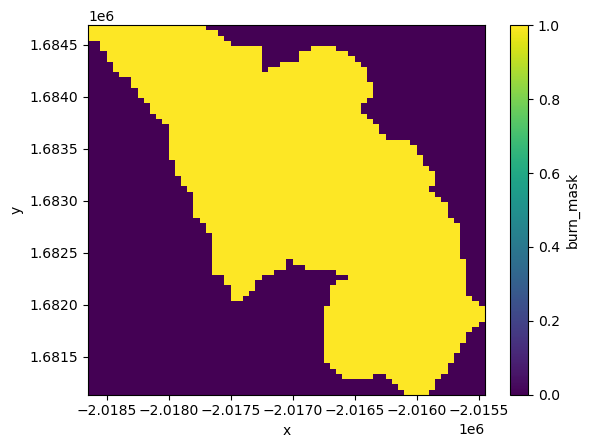

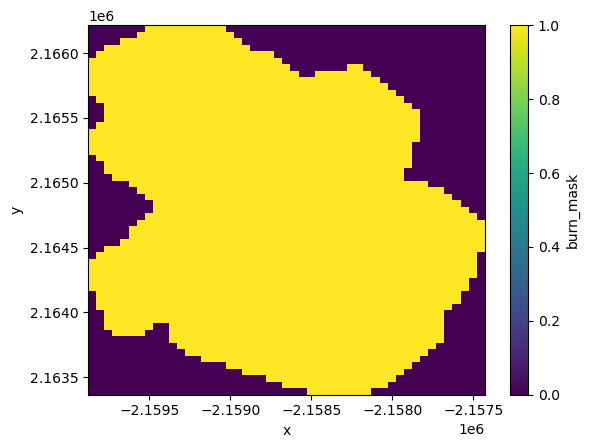

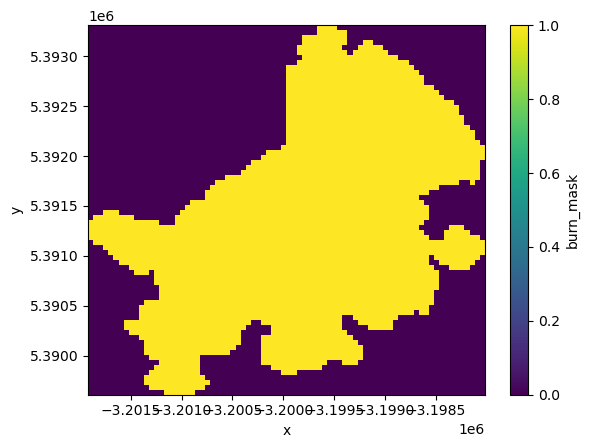

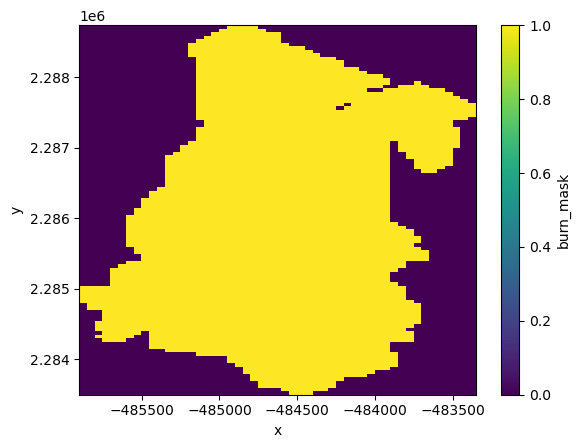

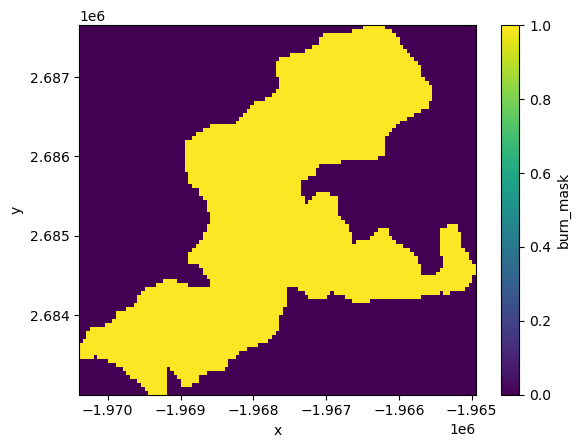

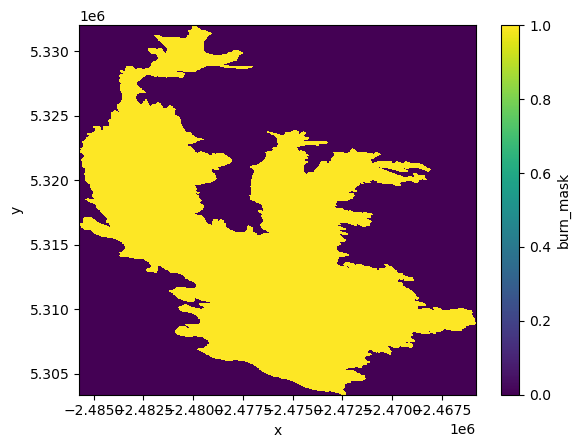

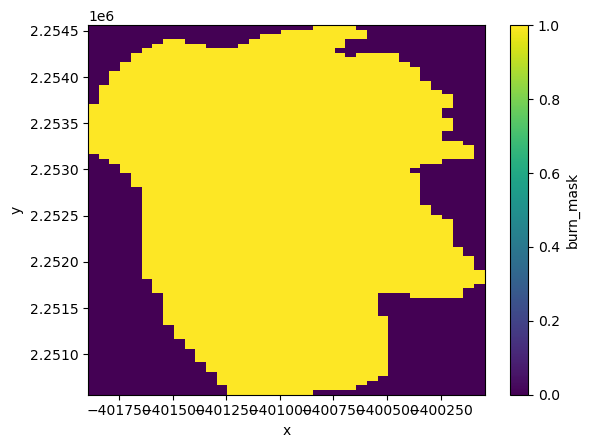

In [ ]:
import random, xarray as xr, geopandas as gpd, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

fires = [p for p in Path("mtbs_demo/results/zarr").glob("*.zarr")]
for z in random.sample(fires, k=min(10, len(fires))):
    da = xr.open_zarr(z)["burn_mask"]
    fid = da.attrs.get("fire_id", z.stem)
    feat = gpd.read_file(f"mtbs_demo/results/features/{fid}.geojson").to_crs(da.attrs["crs"])
    x = da["x"].values; y = da["y"].values
    extent = [x.min(), x.max(), y.min(), y.max()]
    da.plot()
    plt.show()



## Recap / Next steps
- `rule all` sets final targets; the engine builds prerequisites automatically.  
- Wildcards generalize rules; use `-np` and graphs for insight and debugging.  
- Prefer `script:` + the `snakemake` object for clean Python.  
- Next lecture: **HPC** — same workflow, different executor/profile.
